# Rail network exploration



## Goal
* Understand the BOF rail netwrok dataset. 
* Merge it with the intermodal data set.
* Simplify this merged dataset (remove unnecesary nodes).

In [1]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections
import osmnx as ox
from shapely.geometry import Polygon, LineString
import time
import re

import sys
sys.path.append('../utils/')

import simplify

pd.set_option('display.max_columns', None)

## Import BOF data sets

In [2]:
start = time.time()

edges = gpd.read_file('rail_data/North_American_Rail_Lines-shp/North_American_Rail_Lines.shp')
print(f'time elapsed: {time.time()-start}')

start = time.time()

nodes = gpd.read_file('rail_data/North_American_Rail_Nodes-shp/North_American_Rail_Nodes.shp')
print(f'time elapsed: {time.time()-start}')

time elapsed: 24.095784902572632
time elapsed: 10.172541856765747


In [3]:
edges.head(2)

,OBJECTID,FRAARCID,FRFRANODE,TOFRANODE,STFIPS,CNTYFIPS,STCNTYFIPS,STATEAB,COUNTRY,FRAREGION,RROWNER1,RROWNER2,RROWNER3,TRKRGHTS1,TRKRGHTS2,TRKRGHTS3,TRKRGHTS4,TRKRGHTS5,TRKRGHTS6,TRKRGHTS7,TRKRGHTS8,TRKRGHTS9,SUBDIV,YARDNAME,PASSNGR,STRACNET,TRACKS,DIRECTION,CARDDIRECT,NET,MILES,KM,TIMEZONE,IM_RT_TYPE,DS,ShapeSTLen,geometry
0,1,300000,348741,348746,38,015,38015,ND,US,8,DMVW,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.0,2.0,None,M,0.178100,0.286624,C,None,None,418.656726,"LINESTRING (-100.74520 46.80284, -100.74508 46..."
1,2,300001,338567,338686,30,087,30087,MT,US,8,BNSF,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.0,NaN,None,O,0.887103,1.427657,M,None,None,2047.011640,"LINESTRING (-106.65758 45.86404, -106.65768 45..."


Source: https://data-usdot.opendata.arcgis.com/datasets/north-american-rail-lines-1

# Filter the data to keep only florida

AttributeError: 'GeoDataFrame' object has no attribute 'u'

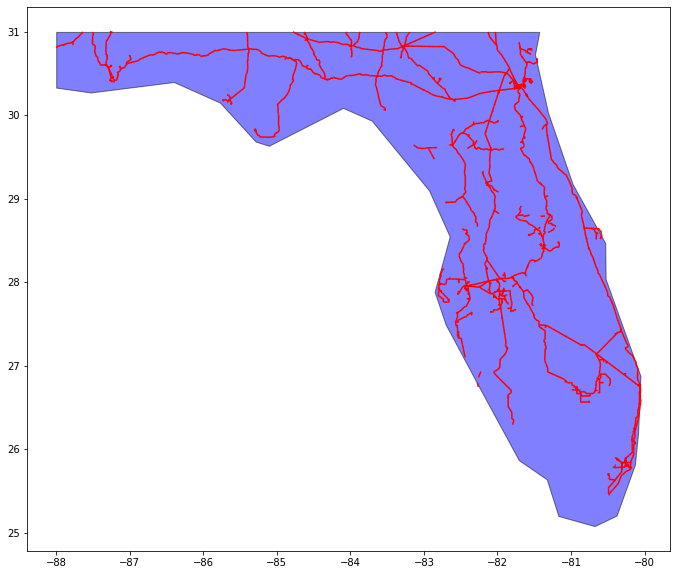

In [4]:
florida_polygon = Polygon([(-88, 24), (-88, 31), (-79, 31), (-79, 24)])

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
n_america = world[world["name"] == "United States of America"]

fig, ax = plt.subplots(figsize=(17,10))

florida_map = gpd.clip(n_america, florida_polygon)
florida_map.plot(ax=ax, edgecolor="black", color = "blue", alpha=0.5)

edges = gpd.clip(edges, florida_polygon)
edges.plot(ax=ax, color="red")



## Format the geodataframes

In [ ]:
def keep_only_valid_usa_rail(nodes, edges):

    edges = edges[edges.eval("(NET == 'I' | NET == 'M') &  COUNTRY == 'US'")]
    nodes = nodes[nodes.FRANODEID.isin(list(edges.u.values) + list(edges.v.values))]


def format_gpdfs(nodes, edges, inplace=True):
    
    start = time.time()
    if not inplace:
        nodes = nodes.copy()
        edges = edges.copy()

    edges.rename(columns={'FRFRANODE':'u','TOFRANODE':'v'}, inplace=True)
    edges['length'] = edges['KM']*1000
    edges['mode'] = 'rail'
    edges['CO2_eq_kg'] = pd.eval('edges.length /1000 * 0.0195254')
    edges['key'] = 0

    nodes['mode'] = 'rail'
    nodes['key'] = 0
    
    keep_only_valid_usa_rail(nodes, edges)
    nodes = nodes[nodes.FRANODEID.isin(list(edges.u.values) + list(edges.v.values))]

    edges.drop(columns=['YARDNAME','CNTYFIPS','STCNTYFIPS','STATEAB','COUNTRY','FRAREGION','SUBDIV','CARDDIRECT','MILES', 'KM','ShapeSTLen','geometry'],inplace=True)
    nodes.drop(columns=['OBJECTID','COUNTRY','STFIPS','CTYFIPS','FRAREGION','BNDRY','PASSNGR','PASSNGRSTN'],inplace=True)
    nodes.set_index('FRANODEID', drop=False, inplace=True)
    print(f'time elapsed: {time.time()-start}')

format_gpdfs(nodes, edges)

In [ ]:
edges.head(2)

In [ ]:
edges.TRACKS.value_counts()

This column is the track type, the FRA defined the tracktype as the speed at which trains can drive.
URL: https://en.wikipedia.org/wiki/Rail_speed_limits_in_the_United_States#Track_classes

One can observe many 0 Tracks. This is because there are many very short tracks in this data set (many of them are unused)

In [ ]:
def add_speed_duration(edges):
    start = time.time()
    
    track_to_speed_map = {0:10,1:16,2:40,3:64,4:97,5:130,6:180,13:97}
    edges['speed_kmh'] = edges.TRACKS.replace(track_to_speed_map)
    edges['duration_h'] = pd.eval('edges.length * 1000 / shp_lines.speed_kmh')
    print(f'time elapsed: {time.time()-start}')
    return edges


Lets zoom in the Florida region to better understand the network 

In [ ]:
def lane_filter_by_operator(shp_file, operators):
    # Filters the dataset, only keep the specified operators.
    
    mask = shp_lines.isin(operators).any(axis=1)
    filtered_shp_lines = shp_lines[mask]
    return filtered_shp_lines

## Adding the intermodal facilities

In [ ]:
intermodal_nodes = gpd.read_file('rail_data/Intermodal stations/Intermodal_Freight_Facilities_RailTOFCCOFC.shp')

In [ ]:
intermodal_nodes.head(2)

In [ ]:
def add_x_y_pos(gdf):
    start = time.time()
    pattern = re.compile(r'(-?\d+\.\d+)')

    coords = gdf.geometry.astype('str').str.extractall(pattern).unstack(level=-1)
    coords.columns = coords.columns.droplevel()
    coords.rename(columns={0: 'x', 1: 'y'}, inplace=True)
    gdf['x'] = coords.x.astype(float) #Carefull this only works for USA
    gdf['y'] = coords.y.astype(float)
    print(f'time elapsed: {time.time()-start}')

In [ ]:
add_x_y_pos(intermodal_nodes)
add_x_y_pos(nodes)

### Create a mapping from nodes to intermodal nodes

In [ ]:
def map_rail_to_intermodal_nodes(intermodal_nodes, nodes):
    rail_node = []
    start = time.time()
    for row in intermodal_nodes.itertuples():
        dist = pd.eval('(nodes.x-row.x)**2 + (nodes.y-row.y)**2')
        rail_node.append(dist.idxmin())

    rail_to_intermodal_map = pd.Series(intermodal_nodes.OBJECTID.values, index=rail_node)
    print(f'time elapsed: {time.time()-start}')
    return rail_to_intermodal_map

intermodal_map = map_rail_to_intermodal_nodes(intermodal_nodes, nodes)

In [ ]:
intermodal_map

In [ ]:
nodes[nodes.FRANODEID<200]

In [ ]:
def add_intermodal_nodes(intermodal_map, nodes, edges):
    start = time.time()
    nodes.loc[:,'FRANODEID'].replace(intermodal_map, inplace=True)
    edges.loc[:,['u','v']] = edges.loc[:,['u','v']].replace(intermodal_map)
    print(f'time elapsed: {time.time()-start}')
    
    
add_intermodal_nodes(intermodal_map,nodes,edges)

In [ ]:
G = ox.graph_from_gdfs(nodes, edges)

In [ ]:
fig, ax = ox.plot_graph(G,node_color='blue',bgcolor='white',node_alpha=0.5,edge_color='black')

In [ ]:
nodes_to_keep = list(nodes[nodes.index < 200].index)
attributes_to_sum = ['length','CO2_eq_kg','duration_h','geometry']

G_s = simplify.simplify_graph(G,attributes_to_sum = attributes_to_sum,nodes_to_keep=nodes_to_keep)

In [ ]:
fig, ax = ox.plot_graph(G_s,node_color='blue',bgcolor='white',node_alpha=0.5,edge_color='black')

In [ ]:
G_u = G_s.to_undirected()
largest_cc_nodes = max(nx.connected_components(G_u), key=len)
largest_cc = G_u.subgraph(largest_cc_nodes).copy()

fig, ax = ox.plot_graph(largest_cc,node_color='blue',bgcolor='white',node_alpha=0.5)

In [ ]:
nx.write_gpickle(largest_cc,'rail_data/simplified_rail_net_florida.plk')

The whole data set has now been cleaned.